In [324]:
#import libraries
import numpy as np
import pandas as pd       
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [325]:
#load data
df_main = pd.read_csv('../data/model_data.csv', low_memory=False)

In [326]:
#establish model variables

X = df_main['combinedtext']
y = df_main['label']

cvec = CountVectorizer(max_features = 1000, stop_words = 'english')

#convert back to dataframe
X_cvec = pd.DataFrame(cvec.fit_transform(X).todense(),
                      columns = cvec.get_feature_names_out())

In [327]:
# Split the data into the training and testing sets. random state set to 88
X_train, X_test, y_train, y_test = train_test_split(X_cvec,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=88)

<b>Define Functions for Modeling</b>

In [328]:
#to obtain probabilities for specific keywords
def cal_mean(source, brand, text):

    if source == 1: #train
        if brand == 0: #flstudio
            try:
                text = combined_train.loc[(combined_train['label'] == 0)].filter(regex=text).values.mean()
                return text
            except:
                return text
        else: 
            try: #ableton
                text = combined_train.loc[(combined_train['label'] == 1)].filter(regex=text).values.mean()
                return text
            except:
                return text
    else: #test
        if brand == 0: #flstudio
            try:
                text = combined_test.loc[(combined_test['label'] == 0)].filter(regex=text).values.mean()
                return text
            except:
                return text
        else: 
            try: #ableton
                text = combined_test.loc[(combined_test['label'] == 1)].filter(regex=text).values.mean()
                return text
            except:
                return text

In [329]:
combined_train = X_train.copy(deep=True)
combined_train['label'] = y_train.copy(deep=True)
combined_test = X_test.copy(deep=True)
combined_test['label'] = y_test.copy(deep=True)

<b>Random Forest Classifier</b><br/><br/>
train cross validation score = 0.909<br/>
test cross valiadation score = 0.909<br/>
accuracy = 91%<br/>
type 1 error (FP) = 402/7982 = 5.0%<br/>
type 2 error (FN) = 289/7982 = 3.6%<br/><br/>
<b>The train and test score shows that the fitting is good. The accuracy is fairly high and the Type 1 and 2 errors are resonably low. There isn't a strong pressure to further reduce the errors. This result is faily similar to K-Nearest Neighbour Classifier but RFC is marginally better overall.<b/>

In [330]:
#identify the best model using Grid Search
rfc = RandomForestClassifier()

rfc_params = {'n_estimators': [100, 150, 200], 'max_depth': [None, 1, 2, 3, 4, 5]}
rfc_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=88)

rfc_gs = GridSearchCV(rfc, rfc_params, cv=rfc_cv)
rfc_gs.fit(X_train, y_train)

print(rfc_gs.best_score_)
print(rfc_gs.best_params_)

0.908788051880793
{'max_depth': None, 'n_estimators': 100}


In [331]:
rfc_gs.score(X_train, y_train)

0.9999382868427549

In [332]:
rfc_gs.score(X_test, y_test)

0.9128038085692809

In [333]:
rfc = RandomForestClassifier(n_estimators = rfc_gs.best_params_['n_estimators'], max_depth = rfc_gs.best_params_['max_depth'])
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [334]:
cross_val_score(rfc, X_train, y_train, cv=rfc_cv).mean()

0.907121918340302

In [335]:
cross_val_score(rfc, X_test, y_test, cv=rfc_cv).mean()

0.9069163835747066

In [336]:
#indentify keywords that are driving identification
df = pd.DataFrame(rfc.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)

df.reset_index(inplace=True)
df = df.rename(columns = {'index':'keyword'})
df = df.rename(columns = {0:'importance'})

#brand 1 = ableton and 0 = flstudio 
#source 1 = train and 0 = test
df['ableton_train'] = [cal_mean(1, 1, x) for x in df["keyword"]]
df['flstudio_train'] = [cal_mean(1, 0, x) for x in df["keyword"]]
df['ableton_test'] = [cal_mean(0, 1, x) for x in df["keyword"]]
df['flstudio_test'] = [cal_mean(0, 0, x) for x in df["keyword"]]

In [337]:
#top 10 influencial words by importance
df.head(10)

,keyword,importance,ableton_train,flstudio_train,ableton_test,flstudio_test
0,ableton,0.142395,0.293501,0.008181,0.303360,0.007489
1,fl_studio,0.081147,0.027583,0.534007,0.024842,0.490068
2,fl,0.076905,0.024524,0.272778,0.022857,0.258548
3,live,0.026077,0.145898,0.006801,0.153370,0.007815
4,ableton_live_11,0.016253,0.152558,0.000321,0.162085,0.000000
5,playlist,0.012502,0.004614,0.101700,0.003054,0.101270
6,mixer,0.009954,0.030391,0.155438,0.033394,0.158255
7,ableton_live,0.009756,0.094383,0.001203,0.100896,0.001710
8,11,0.009720,0.141926,0.008983,0.151598,0.007815
9,ableton_live_10,0.009397,0.101204,0.000481,0.106088,0.000000


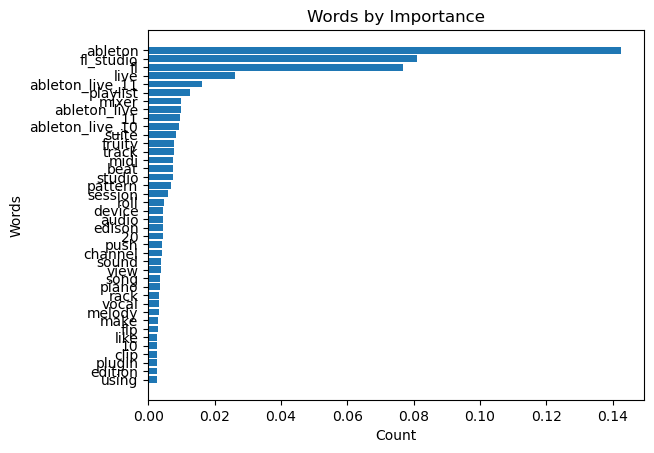

In [338]:
y_axis = list(df.iloc[0:40,0])
x_axis = list(df.iloc[0:40,1])
y_axis.reverse()
x_axis.reverse()

plt.barh(y_axis, x_axis)
plt.title('Words by Importance')
plt.ylabel('Words')
plt.xlabel('Count')
plt.show()

In [339]:
df.to_csv(r'../data/rf_df.csv', index=False)

In [340]:
#calculate pred test values
rfc_y_pred_test = rfc.predict(X_test)

In [341]:
#accuracy score
accuracy_score(y_test, rfc_y_pred_test)

0.9121773991480832

In [342]:
#confusion matrix
confusion_matrix(y_test, rfc_y_pred_test)

array([[2667,  404],
       [ 297, 4614]], dtype=int64)

In [343]:
#classification report
print(classification_report(y_test, rfc_y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      3071
           1       0.92      0.94      0.93      4911

    accuracy                           0.91      7982
   macro avg       0.91      0.90      0.91      7982
weighted avg       0.91      0.91      0.91      7982



<b>K-Nearest Neighbour Classifier</b><br/><br/>
train cross validation score = 0.904<br/>
test cross valiadation score = 0.898<br/>
accuracy = 91%<br/>
type 1 error (FP) = 370/7982 = 4.6%<br/>
type 2 error (FN) = 366/7982 = 4.6%<br/><br/>
<b>The train and test score shows that the fitting is good. The accuracy is fairly high and the Type 1 and 2 errors are resonably low. There isn't a strong pressure to further reduce the errors. This result is faily similar to Random Forest Classifier but RFC is marginally better overall.<b/>

In [344]:
#identify the best model using Grid Search

knnc = KNeighborsClassifier()

knnc_params = {'n_neighbors': list(range(1, 31))}
knnc_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=88)

knnc_gs = GridSearchCV(knnc, knnc_params, cv=knnc_cv)
knnc_gs.fit(X_train, y_train)

print(knnc_gs.best_score_)
print(knnc_gs.best_params_)

0.7756732621990693
{'n_neighbors': 30}


In [345]:
knnc_gs.score(X_train, y_train)

0.7944334732164897

In [346]:
knnc_gs.score(X_test, y_test)

0.7617138561763969

In [347]:
knnc = RandomForestClassifier(n_estimators = knnc_gs.best_params_['n_neighbors'])
knnc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30)

In [348]:
cross_val_score(knnc, X_train, y_train, cv=10).mean()

0.9024321977745788

In [349]:
cross_val_score(knnc, X_test, y_test, cv=10).mean()

0.8986474320971389

In [350]:
#indentify keywords that are driving identification
df = pd.DataFrame(knnc.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)

df.reset_index(inplace=True)
df = df.rename(columns = {'index':'keyword'})
df = df.rename(columns = {0:'importance'})

#brand 1 = ableton and 0 = flstudio 
#source 1 = train and 0 = test
df['ableton_train'] = [cal_mean(1, 1, x) for x in df["keyword"]]
df['flstudio_train'] = [cal_mean(1, 0, x) for x in df["keyword"]]
df['ableton_test'] = [cal_mean(0, 1, x) for x in df["keyword"]]
df['flstudio_test'] = [cal_mean(0, 0, x) for x in df["keyword"]]

In [351]:
#top 10 influencial words
df.head(10)

,keyword,importance,ableton_train,flstudio_train,ableton_test,flstudio_test
0,ableton,0.155158,0.293501,0.008181,0.303360,0.007489
1,fl_studio,0.076036,0.027583,0.534007,0.024842,0.490068
2,fl,0.072296,0.024524,0.272778,0.022857,0.258548
3,live,0.025638,0.145898,0.006801,0.153370,0.007815
4,ableton_live_11,0.016280,0.152558,0.000321,0.162085,0.000000
5,mixer,0.010161,0.030391,0.155438,0.033394,0.158255
6,midi,0.010013,0.515045,0.251684,0.554470,0.233149
7,beat,0.009987,0.069809,0.232435,0.069232,0.209704
8,ableton_live,0.009551,0.094383,0.001203,0.100896,0.001710
9,playlist,0.009291,0.004614,0.101700,0.003054,0.101270


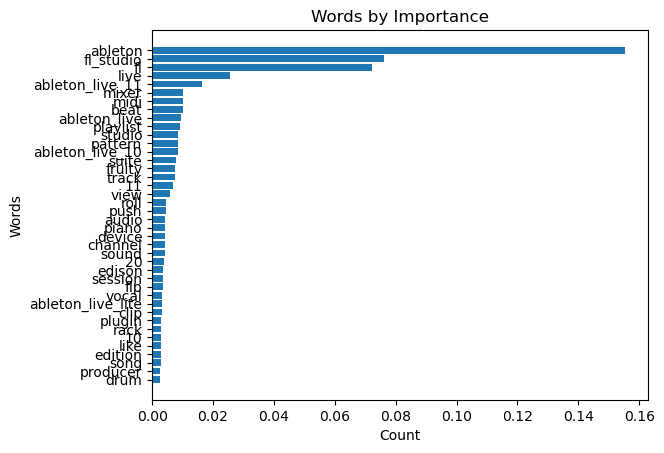

In [352]:
y_axis = list(df.iloc[0:40,0])
x_axis = list(df.iloc[0:40,1])
y_axis.reverse()
x_axis.reverse()

plt.barh(y_axis, x_axis)
plt.title('Words by Importance')
plt.ylabel('Words')
plt.xlabel('Count')
plt.show()

In [353]:
df.to_csv(r'../data/knnc_df.csv', index=False)

In [354]:
#calculate pred test values
knnc_y_pred_test = knnc.predict(X_test)

In [355]:
#accuracy score
accuracy_score(y_test, knnc_y_pred_test)

0.9076672513154598

In [356]:
#confusion matrix
confusion_matrix(y_test, knnc_y_pred_test)

array([[2670,  401],
       [ 336, 4575]], dtype=int64)

In [357]:
#classification report
print(classification_report(y_test, knnc_y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3071
           1       0.92      0.93      0.93      4911

    accuracy                           0.91      7982
   macro avg       0.90      0.90      0.90      7982
weighted avg       0.91      0.91      0.91      7982



<b>Support Vector Machines</b><br/><br/>
train cross validation score = 0.894<br/>
test cross valiadation score = 0.882<br/>
accuracy = 0.90%<br/>
type 1 error (FP) = 405/7982 = 5.0%<br/>
type 2 error (FN) = 420/7982 = 5.0%<br/><br/>
<b>The train and test score shows that the fitting is good. The accuracy is fairly high and the Type 1 and 2 errors are resonably low. There isn't a strong pressure to further reduce the errors. RFC is still marginally better overall.<b/>

In [358]:
#identify the best model using Grid Search

svc = LinearSVC(max_iter=40000)

# C values to GridSearch over
svc_params = {"C": np.linspace(0.0001, 2, 10)}

svc_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=88)

svc_gs = GridSearchCV(svc, svc_params, cv=svc_cv)
svc_gs.fit(X_test, y_test)

print(svc_gs.best_score_)
print(svc_gs.best_params_)

0.8821126658950253
{'C': 0.2223111111111111}


In [359]:
svc_gs.score(X_train, y_train)

0.8779930881263885

In [360]:
svc_gs.score(X_test, y_test)

0.9564019042846404

In [361]:
svc = LinearSVC(max_iter=20000, C = svc_gs.best_params_['C'])

svc.fit(X_train, y_train)

LinearSVC(C=0.2223111111111111, max_iter=20000)

In [362]:
cross_val_score(svc, X_train, y_train, cv=svc_cv).mean()

0.8941006161415374

In [363]:
cross_val_score(svc, X_test, y_test, cv=svc_cv).mean()

0.8821126658950253

In [364]:
#calculate pred test values
svc_y_pred_test = svc.predict(X_test)

In [365]:
#accuracy score
accuracy_score(y_test, svc_y_pred_test)

0.8966424455023804

In [366]:
#confusion matrix
confusion_matrix(y_test, svc_y_pred_test)

array([[2666,  405],
       [ 420, 4491]], dtype=int64)

In [367]:
#classification report
print(classification_report(y_test, svc_y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      3071
           1       0.92      0.91      0.92      4911

    accuracy                           0.90      7982
   macro avg       0.89      0.89      0.89      7982
weighted avg       0.90      0.90      0.90      7982



In [368]:
df.to_csv(r'../data/svm_df.csv', index=False)

In [369]:
y_test_check = y_test.reset_index()
y_test_check['rfc'] = rfc_y_pred_test
y_test_check['knnc'] = knnc_y_pred_test
y_test_check['svc'] = svc_y_pred_test
y_test_check['type1'] = y_test_check.rfc < y_test_check.label
y_test_check['type2'] = y_test_check.rfc > y_test_check.label

<b>Error Examination: A sample of 10 wrongly classified</b><br><br>
<b>Type 1 Error (Classified as FL Studio but is Ableton)</b><br>
Post do not have the clear Ableton and FL Studio keywords, posts seem genuine that can appear in either subreddit.<br><br>
<b>Type 2 Error (Classified as Ableton but is FL Studio)</b><br>
Post do not have the clear Ableton and FL Studio keywords, posts seem genuine that can appear in either subreddit. A few keywords that are more for Ableton appears in these posts.

In [370]:
#Type 1 Error
#random index generated = 19902, 15213, 20472, 21939 and 19883 from code
#y_test_check[y_test_check.type1 == True].sample(n = 5)

,index,label,rfc,knnc,svc,type1,type2
4747,216,1,0,0,1,True,False
5277,3799,1,0,0,1,True,False
7019,14184,1,0,0,0,True,False
7413,11917,1,0,0,0,True,False
2978,2619,1,0,1,0,True,False


In [371]:
#lable as 1 but is 0 (1 = Ableton, 0 = Fl Studio)
df_main.combinedtext[19902]

'way relocate lost sample sound using sample name drum kit solid sound transferring file reason show name sound project file name drum kit way possible know drum kit came device help appreciated lost drum kit'

In [372]:
df_main.combinedtext[15213]

'currently using envelope filter sytrus attempting alter attack decay sustain release adsr using knob moment release one knob turning corresponding adsr setting snap straight back original position short adsr knob work anything done fix sytrus synth adsr knob trouble'

In [373]:
df_main.combinedtext[20472]

'three question couldt find clear answer 1 way make edge detect picture png layer behind right edge detect make png picture background take whole screen apply 2 move around core bump effect x parameter seem work reposition effect 3 make effect apply sertain sound playing know control audio effect et_cetera certain sound way effect example kick play screen get blurry thanks advance need help zgame editor'

In [374]:
df_main.combinedtext[21939]

'hey use standard computer keyboard midi controller proper one yet plugin click presets play immediately keyboard however podolski sektor every time select new preset use keyboard right away either click keyboard within plugin click plugin window frame major issue still use plugin however little annoying repeatedly click somewhere plugin test preset anyone may solution experiencing problem love know thankyou midi keyboard stop working select new preset'

In [375]:
df_main.combinedtext[19883]

'using window 10 output device asio driver trying use asio4all problem literally see one device none dacs try connect get listed actually tried two separate pc even dac also asio driver installed program issue using wasapi exclusive asio4all seems clueless anyone know get asio4all actually see device alternative actually work get asio4all see dacs'

In [376]:
#Type 2 Error
#random index generated = 3619, 7862, 7809, 10261 and 10552 from code
#y_test_check[y_test_check.type2 == True].sample(n = 5)

,index,label,rfc,knnc,svc,type1,type2
4736,20499,0,1,1,0,False,True
2661,20346,0,1,1,0,False,True
6622,20797,0,1,1,0,False,True
4106,18088,0,1,0,0,False,True
2799,23776,0,1,1,0,False,True


In [377]:
#lable as 0 but is 1 (1 = Ableton, 0 = Fl Studio)
df_main.combinedtext[3619]

'know even articulate tried search know give order like channel sound parameter delay feedback example also increase similar amount want example make return channel reverb increase volume gain distortion plugin strip increase proportionally volume plugin decrease guess something like cv function thank way automate automation like sidechain different parameter'

In [378]:
df_main.combinedtext[7862]

'play melody chord using midi keyboard raise lower velocity individual note nothing happens draw melody chord velocity altered normal idea setting could causing thanks velocity cannot manually altered played keyboard idea'

In [379]:
df_main.combinedtext[7809]

'trying find sort simple tool app vst essentially work chord bank 12 note several chord value laid button look picture ominchord pad play chord 12 note major minor 7th value sort app essentially even chord value major chord minor chord diminished chord major seventh chord minor seventh chord dominant seventh chord suspended chord sus2 sus4 et_cetera need goofy strum rhythm section omnichord ha want big chord bank tap click hear played anything like exist everytime look chord generator keep finding endlessly complicated vst insanely basic iphone apps work looking omnichord style chord generator app vst loss help'

In [380]:
df_main.combinedtext[10261]

'hello ambient piece like cut whole minute sound way select cut everything moved forward section b c remove section b c flawless seems delete midiclips automation moving automation hand get quite cumbersome never really replicate done delete whole section move automation forward'

In [381]:
df_main.combinedtext[10552]

'searched ol oracle seen people problem solution read working driving crazy matter hit record clip give count started recording immediately sure something simple sure find count greyed way metronome anyone help much obliged count count greyed trying record driving nut'

<b>Model Evaluation Summary</b>

|Model|Train Cross Validation|Test Cross Validation|Accuracy|Type 1 Error|Type 2 Error|
|:---|---:|---:|---:|---:|---:|
|Random Forest Classifier|0.909|0.909|91%|5.1%|3.6%|
|K-Nearest Neighbour Classifier|0.904|0.898|91%|4.6%|4.6%|
|Support Vector Machines|0.894|0.882|90%|5.0%|5.0%|

<b>All the three models have good results but the Random Forest Classifier has a slight edge over the others. It was, all, a very close fight between the models.</b>

<b>Findings</b>

In [382]:
#reload result data
df_result = pd.read_csv(r'../data/rf_df.csv', low_memory=False)

In [383]:
#create comparison - which is more for Ableton of FL Studio
df_result['more_ableton'] = df_result.ableton_train > df_result.flstudio_train

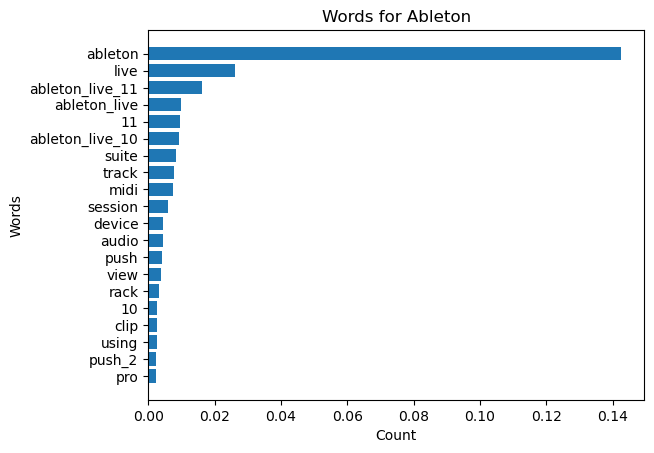

In [384]:
    #show the top important words more closely related to Ableton
df_result_ableton = df_result[df_result.more_ableton == True]
y_axis = list(df_result_ableton.iloc[0:20,0])
x_axis = list(df_result_ableton.iloc[0:20,1])
y_axis.reverse()
x_axis.reverse()

plt.barh(y_axis, x_axis)
plt.title('Words for Ableton')
plt.ylabel('Words')
plt.xlabel('Count')
plt.show()

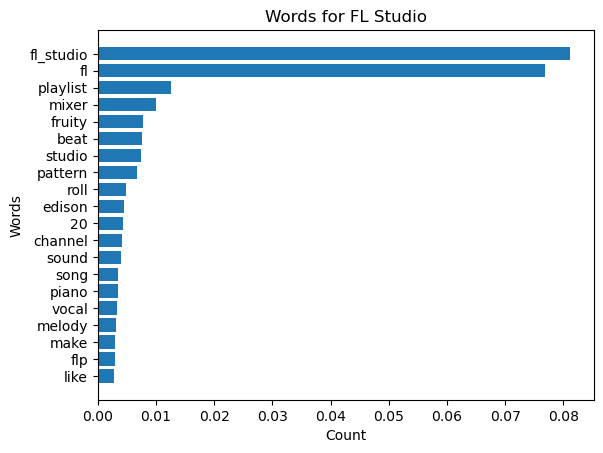

In [385]:
#show the top important words more closely related to Fl Studio
df_result_ableton = df_result[df_result.more_ableton == False]
y_axis = list(df_result_ableton.iloc[0:20,0])
x_axis = list(df_result_ableton.iloc[0:20,1])
y_axis.reverse()
x_axis.reverse()

plt.barh(y_axis, x_axis)
plt.title('Words for FL Studio')
plt.ylabel('Words')
plt.xlabel('Count')
plt.show()